In [20]:
from understatapi import UnderstatClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

understat = UnderstatClient()

Przykladowy mecz z tego sezonu

In [21]:
league_data = understat.league(league="EPL").get_match_data(season="2024")

league_data[8]

{'id': '26610',
 'isResult': True,
 'h': {'id': '80', 'title': 'Chelsea', 'short_title': 'CHE'},
 'a': {'id': '88', 'title': 'Manchester City', 'short_title': 'MCI'},
 'goals': {'h': '0', 'a': '2'},
 'xG': {'h': '1.06123', 'a': '1.18038'},
 'datetime': '2024-08-18 15:30:00',
 'forecast': {'w': '0.3036', 'd': '0.3245', 'l': '0.3719'}}

funkcja tworzaca dataframe dla wybranej ligi i sezonu

In [73]:
def get_league_data(league: str, seasons: list):
    understat = UnderstatClient()
    all_matches = []
    
    for season in seasons:
        league_data = understat.league(league=league).get_match_data(season=season)
        for match in league_data:
            # Zdarza się, że w "forecast" może nie być danych, więc obsługujemy to przez get() lub warunek
            forecast = match.get("forecast", {})
            
            match_data = {
                "league": league,
                "season": season,
                "match_id": match["id"],
                "date": match["datetime"],
                "home_team": match["h"]["title"],
                "away_team": match["a"]["title"],
                "home_goals": match["goals"]["h"],
                "away_goals": match["goals"]["a"],
                "home_xG": match["xG"]["h"],
                "away_xG": match["xG"]["a"],
                "win_prob": forecast.get("w"),   # prawdopodobieństwo zwycięstwa gospodarza według Understat
                "draw_prob": forecast.get("d"), # prawdopodobieństwo remisu
                "away_win_prob": forecast.get("l") # prawdopodobieństwo wygranej gości
            }
            all_matches.append(match_data)

    df = pd.DataFrame(all_matches)
    return df

wezmiemy dane z sezonu 23/24 premier league

In [74]:
seasons = ["2023"]
df_epl = get_league_data("EPL", seasons)

print(df_epl.head())

df_epl.to_csv("data_epl_2023_2024.csv", index=False)
print("Data saved.")

  league season match_id                 date    home_team          away_team  \
0    EPL   2023    22275  2023-08-11 19:00:00      Burnley    Manchester City   
1    EPL   2023    22276  2023-08-12 11:30:00      Arsenal  Nottingham Forest   
2    EPL   2023    22277  2023-08-12 14:00:00  Bournemouth           West Ham   
3    EPL   2023    22278  2023-08-12 14:00:00     Brighton              Luton   
4    EPL   2023    22279  2023-08-12 14:00:00      Everton             Fulham   

  home_goals away_goals   home_xG   away_xG win_prob draw_prob away_win_prob  
0          0          3  0.311032   2.40074   0.0177    0.0854        0.8969  
1          2          1   0.84262  0.966305   0.2797    0.3363         0.384  
2          1          1   1.51025    1.4834   0.3559    0.3169        0.3272  
3          4          1   4.36748   1.88594    0.879    0.0876        0.0334  
4          0          1   2.59001   1.58144   0.6371    0.1989         0.164  
Data saved.


In [23]:
df = pd.read_csv("data_epl_2023_2024.csv")
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   league         380 non-null    object 
 1   season         380 non-null    int64  
 2   match_id       380 non-null    int64  
 3   date           380 non-null    object 
 4   home_team      380 non-null    object 
 5   away_team      380 non-null    object 
 6   home_goals     380 non-null    int64  
 7   away_goals     380 non-null    int64  
 8   home_xG        380 non-null    float64
 9   away_xG        380 non-null    float64
 10  win_prob       380 non-null    float64
 11  draw_prob      380 non-null    float64
 12  away_win_prob  380 non-null    float64
dtypes: float64(5), int64(4), object(4)
memory usage: 38.7+ KB
None
league           0
season           0
match_id         0
date             0
home_team        0
away_team        0
home_goals       0
away_goals       0
home_xG        

funkcja tworzaca kolumne wskazujaca na zwyciezce 
 na podstawie zdobytych goli

In [24]:
df['date'] = pd.to_datetime(df['date'])

def get_result(row):
    if row['home_goals'] > row['away_goals']:
        return 1
    elif row['home_goals'] < row['away_goals']:
        return -1
    else:
        return 0


df['match_result'] = df.apply(get_result, axis=1)

df.head()


,league,season,match_id,date,home_team,away_team,home_goals,away_goals,home_xG,away_xG,win_prob,draw_prob,away_win_prob,match_result
0,EPL,2023,22275,2023-08-11 19:00:00,Burnley,Manchester City,0,3,0.311032,2.400740,0.0177,0.0854,0.8969,-1
1,EPL,2023,22276,2023-08-12 11:30:00,Arsenal,Nottingham Forest,2,1,0.842620,0.966305,0.2797,0.3363,0.3840,1
2,EPL,2023,22277,2023-08-12 14:00:00,Bournemouth,West Ham,1,1,1.510250,1.483400,0.3559,0.3169,0.3272,0
3,EPL,2023,22278,2023-08-12 14:00:00,Brighton,Luton,4,1,4.367480,1.885940,0.8790,0.0876,0.0334,1
4,EPL,2023,22279,2023-08-12 14:00:00,Everton,Fulham,0,1,2.590010,1.581440,0.6371,0.1989,0.1640,-1


In [25]:
print(df[["home_goals","away_goals","home_xG","away_xG"]].describe())

       home_goals  away_goals     home_xG     away_xG
count  380.000000  380.000000  380.000000  380.000000
mean     1.800000    1.478947    1.922032    1.458510
std      1.365616    1.277811    1.033890    0.899809
min      0.000000    0.000000    0.088624    0.028155
25%      1.000000    1.000000    1.110132    0.802416
50%      2.000000    1.000000    1.762235    1.291850
75%      3.000000    2.000000    2.628137    1.929960
max      6.000000    8.000000    6.671510    5.108200


In [27]:
corr_home = df["home_xG"].corr(df["home_goals"])
corr_away = df["away_xG"].corr(df["away_goals"])
print("Korelacja home_xG z home_goals:", corr_home)
print("Korelacja away_xG z away_goals:", corr_away)

Korelacja home_xG z home_goals: 0.5931873663538461
Korelacja away_xG z away_goals: 0.6510022495076635


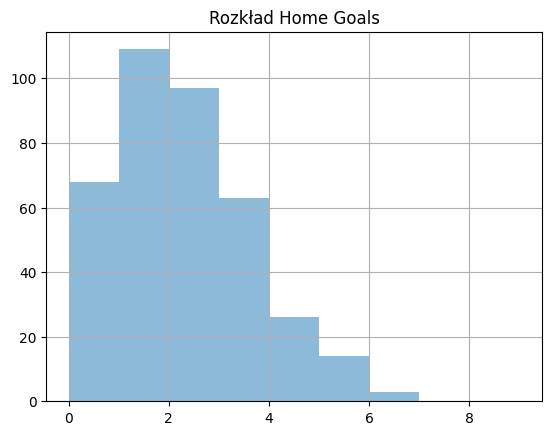

In [28]:
df["home_goals"].hist(bins=range(0,10), alpha=0.5)
plt.title("Rozkład Home Goals")
plt.show()

poisson oraz funkcja tworzaca prawdopodobienstwa wyniku meczu

In [ ]:
def poisson_prob(k, lam):
    return (math.exp(-lam) * (lam**k)) / math.factorial(k)


def predict_match_poisson(home_xg, away_xg, max_goals=8):
    p_home_win = 0
    p_draw = 0
    p_away_win = 0

    for h_goals in range(max_goals+1):
        for a_goals in range(max_goals+1):
            ph = poisson_prob(h_goals, home_xg)
            pa = poisson_prob(a_goals, away_xg)
            p = ph * pa

            if h_goals > a_goals:
                p_home_win += p
            elif h_goals == a_goals:
                p_draw += p
            else:
                p_away_win += p

    return p_home_win, p_draw, p_away_win


home_xg_example = 2.5
away_xg_example = 0.33
p_home_win, p_draw, p_away_win = predict_match_poisson(home_xg_example, away_xg_example)
print(p_home_win, p_draw, p_away_win, (p_home_win + p_draw + p_away_win))


0.8467967676284069 0.11870939009600155 0.03335358934801916 0.9988597470724276


skutecznosc na poziomie calego sezonu

In [32]:
correct = 0
total = 0

for i, row in df.iterrows():
    hxg = row["home_xG"]
    axg = row["away_xG"]
    p_home, p_draw, p_away = predict_match_poisson(hxg, axg)

    # przewidywany wynik = kto ma najwyższe p
    if p_home > p_draw and p_home > p_away:
        pred = 1
    elif p_draw > p_home and p_draw > p_away:
        pred = 0
    else:
        pred = -1

    actual = row["match_result"]
    if pred == actual:
        correct += 1
    total += 1

accuracy = correct / total * 100
print(f"Accuracy modelu Poissona: {accuracy:.2f}%")


Accuracy modelu Poissona: 62.63%


tworzymy nowy df zawierajacy kolumny: druzyne, srednie xG i srednie xG allowed (potrzebnne do modelu SxGM)

In [ ]:
rows = []

for i, row in df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    
    home_xg = row["home_xG"]
    away_xg = row["away_xG"]

    rows.append({
        "team": home_team,
        "xG": home_xg,
        "xGA": away_xg  
    })
    rows.append({
        "team": away_team,
        "xG": away_xg,
        "xGA": home_xg
    })

df_teams = pd.DataFrame(rows)
df_teams['xG'] = df_teams['xG'].astype(float)
df_teams['xGA'] = df_teams['xGA'].astype(float)

df_team_avg = df_teams.groupby("team", as_index=False).mean()

df_team_avg

,team,xG,xGA
0,Arsenal,2.220855,0.836372
1,Aston Villa,1.774279,1.712521
2,Bournemouth,1.677775,1.723886
3,Brentford,1.691886,1.585807
4,Brighton,1.629221,1.603610
5,Burnley,1.143213,1.992587
6,Chelsea,2.128461,1.647380
7,Crystal Palace,1.419354,1.526075
8,Everton,1.598794,1.585713
9,Fulham,1.389703,1.760635


skutecznosc zwyklego xGM oraz modyfikacji - SxGM

In [72]:
correct_xGM = 0
correct_sxGM = 0
total = 0

for i, row in df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    hxg = row["home_xG"]  
    axg = row["away_xG"] 
    actual_result = row["match_result"]  


    p_home, p_draw, p_away = predict_match_poisson(hxg, axg)
    if p_home > p_draw and p_home > p_away:
        pred_xGM = 1
    elif p_draw > p_home and p_draw > p_away:
        pred_xGM = 0
    else:
        pred_xGM = -1
    
    if pred_xGM == actual_result:
        correct_xGM += 1


    away_xGA_arr = df_team_avg.loc[df_team_avg["team"] == away_team, "xGA"].values
    home_xGA_arr = df_team_avg.loc[df_team_avg["team"] == home_team, "xGA"].values
    
    away_xGA = away_xGA_arr[0] 
    home_xGA = home_xGA_arr[0]  
    
    lam_home_SxGM = hxg * away_xGA
    lam_away_SxGM = axg * home_xGA
    
    p_home_s, p_draw_s, p_away_s = predict_match_poisson(lam_home_SxGM, lam_away_SxGM)
    if p_home_s > p_draw_s and p_home_s > p_away_s:
        pred_sxGM = 1
    elif p_draw_s > p_home_s and p_draw_s > p_away_s:
        pred_sxGM = 0
    else:
        pred_sxGM = -1

    if pred_sxGM == actual_result:
        correct_sxGM += 1
    
    total += 1

acc_xGM = correct_xGM / total * 100 
acc_sxGM = correct_sxGM / total * 100 

print(f"Liczba meczów: {total}")
print(f"Accuracy (xGM):  {acc_xGM:.2f}%")
print(f"Accuracy (SxGM): {acc_sxGM:.2f}%")


Liczba meczów: 380
Accuracy (xGM):  62.63%
Accuracy (SxGM): 62.89%
